In [1]:
# pip install pyspark
from pyspark import SparkContext, RDD

DIR_PATH = "Sparks_dataset/Sparks_dataset"
DIR_CONTEXT = DIR_PATH + "/Context"
DIR_DATA_FRAME = DIR_PATH + "/Data Frame"
DIR_SPARK_PANDAS = DIR_PATH + "/Spark Pandas"

# Exercise 1 - Basic Order Analysis
Tasks:

1. Load the dataset into Spark using SparkContext and textFile().
2. Count the total number of orders.
3. Calculate the total revenue from all orders.
4. Find the number of unique customers.

In [2]:
# 1. Load the dataset into Spark using SparkContext and textFile().
sc = SparkContext("local", "ST2CBD-Lab2-OrderAnalysis")

# Load the dataset
salesdata_rdd = sc.textFile(f"{DIR_CONTEXT}/salesdata.csv.txt")

25/05/14 20:10:20 WARN Utils: Your hostname, MacBook-Pro-de-Lucas.local resolves to a loopback address: 127.0.0.1; using 10.0.0.18 instead (on interface en0)
25/05/14 20:10:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/14 20:10:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# 2. Count the total number of orders.
# Because the file has 2 header lines, we need to remove them before counting
header = salesdata_rdd.take(2)

# We remove the header lines from the RDD
salesdata_rdd = salesdata_rdd.filter(
    lambda line: line != header[0] and line != header[1]
)

# Count the total number of orders
total_orders = salesdata_rdd.count()

total_orders

10

In the CSV file, we have 2 header lines. In order to count the total number of orders, we need to remove the header lines from the RDD.

Total number of orders: 10

In [4]:
# 3. Calculate the total revenue from all orders.
# Index of OrderAmount is 2

sales_revenues = salesdata_rdd.map(lambda line: float(line.split(",")[2]))

total_revenue = sales_revenues.sum()

total_orders

10

Total orders = 10

In [5]:
# 4. Find the number of unique customers.
# Index of CustomerID is 1

unique_customers = salesdata_rdd.map(lambda line: line.split(",")[1]).distinct()

total_unique_customers = unique_customers.count()

total_unique_customers

6

Total unique customers = 6

In [6]:
sc.stop()

# Exercise 2 - Department Salary Stats
Tasks:

1. Load employee data and skip header.
2. Find total number of employees.
3. Calculate average salary per department.
4. Find department with highest total salary.

In [7]:
# 1. Load employee data and skip header.
sc = SparkContext("local", "ST2CBD-Lab2-DepartmentSalaryStats")

# Load the dataset
salesdata_rdd = sc.textFile(f"{DIR_CONTEXT}/2 salary.csv")

# Skip header
header = salesdata_rdd.take(1)

salesdata_rdd = salesdata_rdd.filter(lambda line: line != header[0])

salesdata_rdd.take(1)

['E101,Alice,Sales,50000']

Result should not be the header and be the first line: ['E101,Alice,Sales,50000']

In [8]:
# 2. Find total number of employees.

total_employees = salesdata_rdd.count()

total_employees

8

Total employees = 8

In [9]:
# 3. Calculate average salary per department.

average_salary_per_department = (
    salesdata_rdd.map(lambda line: (line.split(",")[2], float(line.split(",")[3])))
    .groupByKey()
    .mapValues(lambda salaries: sum(salaries) / len(salaries))
    .collect()
)

average_salary_per_department

[('Sales', 54000.0), ('Marketing', 56500.0), ('IT', 69000.0)]

Departements average salaries:
- Sales: 54000
- Marketing: 56500
- IT: 69000

In [10]:
# 4. Find department with the highest total salary.

highest_salary_department = (
    salesdata_rdd.map(lambda line: (line.split(",")[2], float(line.split(",")[3])))
    .groupByKey()
    .mapValues(lambda salaries: sum(salaries))
    .sortBy(lambda x: x[1], ascending=False)
    .first()
)

highest_salary_department

('IT', 207000.0)

In [11]:
sc.stop()

# Exercise 3: Web Traffic Summary
Dataset: web_logs.txt

Tasks:
1. Load the data and parse it into fields.
2. Count total number of visits per URL.
3. Find unique users per URL.
4. Determine peak hour for traffic.

In [12]:
# 1. Load the data and parse it into fields.

sc = SparkContext("local", "ST2CBD-Lab2-WebTrafficSummary")
web_logs_rdd = sc.textFile(f"{DIR_CONTEXT}/3 web_logs.txt")

# Skip header
header = web_logs_rdd.take(1)
web_logs_rdd = web_logs_rdd.filter(lambda line: line != header[0])

# Parse the data into fields
web_logs_rdd = web_logs_rdd.map(lambda line: line.split(","))

In [13]:
# 2. Count total number of visits per URL.

url_visits = (
    web_logs_rdd.map(lambda fields: (fields[1], 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

url_visits

[('/home', 6), ('/product', 2), ('/contact', 1), ('/about', 1)]

We take the URL and the number of visits -> Reduce by key to count visits (line = 1 visit).

Result: [('/home', 6), ('/product', 2), ('/contact', 1), ('/about', 1)]

In [14]:
# 3. Find unique users per URL.

unique_users_per_url = (
    web_logs_rdd.map(lambda fields: (fields[1], fields[0]))
    .distinct()
    .map(lambda x: (x[0], 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

unique_users_per_url

[('/home', 4), ('/product', 2), ('/contact', 1), ('/about', 1)]

First we take the URL and the user ID -> Remove duplicates -> Reduce by key to count unique users.

Result: [('/home', 4), ('/product', 2), ('/contact', 1), ('/about', 1)]

In [15]:
# 4. Determine peak hour for traffic.
from datetime import datetime

hour_counts = web_logs_rdd.map(
    lambda fields: (datetime.strptime(fields[2], "%Y-%m-%d %H:%M:%S").hour, 1)
).reduceByKey(lambda a, b: a + b)

peak_hour = hour_counts.sortBy(lambda x: x[1], ascending=False).first()

peak_hour

(13, 2)

We take the field index 2 (Timestamp) and convert it to a datetime object -> Get the hour -> Reduce by key to count visits per hour.

After that we sort by the number of visits and take the first one.

Result: (13, 2) -> 13:00 w/ 2 visits

In [16]:
sc.stop()

# Exercise 4: Product Rating Analysis
Tasks: Dataset: product_reviews.csv
1. Load and parse the review data.
2. Calculate the average rating per product.
3. Count number of reviews per product.
4. Find products with all 5-star reviews.

In [17]:
def parse_rdd_csv(file_path, header_lines=1) -> RDD[str]:
    rdd = sc.textFile(file_path)
    header = rdd.take(header_lines)
    rdd = rdd.filter(lambda line: line not in header)

    rdd = rdd.map(lambda line: line.split(","))
    return rdd

Created a function for parsing input files. It takes the file path and the number of header lines to skip (header). It returns an RDD with the parsed data.

In [18]:
# 1. Load and parse the review data.
sc = SparkContext("local", "ST2CBD-Lab2-ProductRatingAnalysis")
production_reviews_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/4 product_reviews.csv")

In [19]:
# 2. Calculate the average rating per product
average_rating_per_product = (
    production_reviews_rdd.map(lambda fields: (fields[1], float(fields[2])))
    .groupByKey()
    .mapValues(lambda ratings: sum(ratings) / len(ratings))
    .collect()
)

average_rating_per_product

[('P001', 5.0), ('P002', 4.0), ('P003', 4.0), ('P004', 5.0), ('P005', 4.0)]

We take the second (product) and third field (score) -> Group by product -> Calculate the average score.

In [20]:
# 3. Count number of reviews per product

reviews_per_product = (
    production_reviews_rdd.map(lambda fields: (fields[1], 1))
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

reviews_per_product

[('P001', 3), ('P002', 2), ('P003', 2), ('P004', 2), ('P005', 1)]

We take the second field (product) and count the number of reviews (each line correspond to one product review).

In [21]:
# 4. Find products with all 5-star reviews.

five_star_products = (
    production_reviews_rdd.map(lambda fields: (fields[1], float(fields[2])))
    .groupByKey()
    .filter(lambda x: all(rating == 5.0 for rating in x[1]))
    .map(lambda x: x[0])
    .collect()
)

five_star_products

['P001', 'P004']

We take the second field (product) and the third field (score) -> Group by product -> Filter products with all 5-star reviews

In [22]:
sc.stop()

# Exercise 5: Movie Ratings Analytics
Objective: Learn to read a CSV file, initialize SparkContext, and perform basic operations.

Tasks:
1. Load the movies.csv using SparkContext.textFile.
2. Count the total number of movies.
3. Filter movies with rating >= 4.
4. Display the top 5 movies by rating.

In [23]:
# 1. Load the movies.csv using SparkContext.textFile.
sc = SparkContext("local", "ST2CBD-Lab2-MovieRatingsAnalytics")
movies_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/5 movies.csv")

In [24]:
# 2. Count the total number of movies.
total_movies = movies_rdd.count()
total_movies

5

1 line = 1 movie

Total movies = 5

In [25]:
# 3. Filter movies with rating >= 4.
movies_rated_4_or_plus = (
    movies_rdd.filter(lambda fields: float(fields[3]) >= 4.0)
    .map(lambda fields: (fields[1], fields[2], float(fields[3])))
    .collect()
)

movies_rated_4_or_plus

[('Inception', 'Sci-Fi', 4.8),
 ('The Dark Knight', 'Action', 4.9),
 ('The Notebook', 'Romance', 4.2),
 ('Interstellar', 'Sci-Fi', 4.7)]

We filter lines with rating >= 4.0 -> We take the second field (movie name), third field (genre) and fourth field (rating).

In [26]:
# 4. Display the top 5 movies by rating. (Sort + Limit)
top_5_movies = (
    movies_rdd.map(lambda fields: (fields[1], fields[2], float(fields[3])))
    .sortBy(lambda fields: float(fields[2]), ascending=False)
    .take(5)
)

top_5_movies

[('The Dark Knight', 'Action', 4.9),
 ('Inception', 'Sci-Fi', 4.8),
 ('Interstellar', 'Sci-Fi', 4.7),
 ('The Notebook', 'Romance', 4.2),
 ('Fast & Furious', 'Action', 3.9)]

We take the second field (movie name), third field (genre) and fourth field (rating) -> Sort by rating -> Take the top 5 movies.

In [27]:
sc.stop()

# Exercise 6: Student Scores Analysis
Objective: Understand RDD transformations and actions.

Tasks:
1. Load data using SparkContext.textFile.
2. Map each line to a key-value pair (name, score).
3. Filter students who scored above 80.
4. Count how many students scored above 80.

In [28]:
# 1. Load data using SparkContext.textFile.
sc = SparkContext("local", "ST2CBD-Lab2-StudentScoresAnalysis")
students_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/6 analysis.csv")

students_rdd.collect()

[['Alice', 'Math', '85'],
 ['Bob', 'Math', '75'],
 ['Charlie', 'Math', '90'],
 ['Diana', 'Math', '88'],
 ['Eve', 'Math', '60']]

In [29]:
# 2. Map each line to a key-value pair (name, score).
students_scores_rdd = students_rdd.map(lambda fields: (fields[0], float(fields[2])))

students_scores_rdd.collect()

[('Alice', 85.0),
 ('Bob', 75.0),
 ('Charlie', 90.0),
 ('Diana', 88.0),
 ('Eve', 60.0)]

We take the first field (name) and the third field (score) -> We create a tuple with the name and score.

In [30]:
# 3. Filter students who scored above 80.
students_above_80 = (
    students_rdd.filter(lambda fields: float(fields[2]) > 80.0)
    .map(lambda fields: (fields[0], fields[1]))
    .collect()
)

students_above_80

[('Alice', 'Math'), ('Charlie', 'Math'), ('Diana', 'Math')]

We filter by score > 80.0 (field n°3) -> We take the first field (name) and the second field (subject).

In [31]:
# 4. Count how many students scored above 80.
count_students_above_80 = students_rdd.filter(
    lambda fields: float(fields[2]) > 80.0
).count()

print(count_students_above_80)

# or
count_students_above_80 = len(students_above_80)
count_students_above_80

3


3

In [32]:
sc.stop()

# Exercise 7: Word Count from News Articles
Objective: Classic Word Count example.

Tasks:
1. Load the news data file.
2. Split lines into words.
3. Map each word to (word, 1).
4. Use reduceByKey to get word counts

In [33]:
# 1. Load the news data file.
sc = SparkContext("local", "ST2CBD-Lab2-WordCount")
news_rdd = sc.textFile(f"{DIR_CONTEXT}/7 wordcount.csv", 0)

news_rdd.collect()

['Spark is fast. Big data is booming. Spark handles big data with ease.']

In [34]:
# 2. Split lines into words.
words_rdd = news_rdd.flatMap(lambda line: line.replace(".", "").split(" "))

words_rdd.collect()

['Spark',
 'is',
 'fast',
 'Big',
 'data',
 'is',
 'booming',
 'Spark',
 'handles',
 'big',
 'data',
 'with',
 'ease']

Split words by space

In [35]:
# 3. Map each word to (word, 1).
word_pairs_rdd = words_rdd.map(lambda word: (word, 1))

word_pairs_rdd.collect()

[('Spark', 1),
 ('is', 1),
 ('fast', 1),
 ('Big', 1),
 ('data', 1),
 ('is', 1),
 ('booming', 1),
 ('Spark', 1),
 ('handles', 1),
 ('big', 1),
 ('data', 1),
 ('with', 1),
 ('ease', 1)]

We take each word and create a tuple with the word and 1 (1 occurrence).

In [36]:
# 4. Use reduceByKey to get word counts
word_counts_rdd = word_pairs_rdd.reduceByKey(lambda a, b: a + b)

word_counts_rdd.collect()

[('Spark', 2),
 ('is', 2),
 ('fast', 1),
 ('Big', 1),
 ('data', 2),
 ('booming', 1),
 ('handles', 1),
 ('big', 1),
 ('with', 1),
 ('ease', 1)]

In [37]:
sc.stop()

# Exercise 8: Product Sales Tracker
Objective: Group and aggregate product sales.

Tasks:
1. Load product sales CSV.
2. Map to (product, revenue).
3. Use reduceByKey to get total revenue.
4. Filter products with revenue > 1000.

In [38]:
# 1. Load product sales CSV.
sc = SparkContext("local", "ST2CBD-Lab2-ProductSalesTracker")
product_sales_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/8 product.csv")

product_sales_rdd.collect()

[['1', 'Mobile', '100', '10'],
 ['2', 'Laptop', '10', '900'],
 ['3', 'Mouse', '200', '5'],
 ['4', 'Keyboard', '150', '10']]

In [39]:
# 2. Map to (product, revenue).
product_revenue_rdd = product_sales_rdd.map(
    lambda fields: (fields[1], float(fields[2]) * float(fields[3]))
)

product_revenue_rdd.collect()

[('Mobile', 1000.0),
 ('Laptop', 9000.0),
 ('Mouse', 1000.0),
 ('Keyboard', 1500.0)]

We take the second field (product) and the third field (revenue) -> We create a tuple with the product and revenue.

In [40]:
# 3. Use reduceByKey to get total revenue.
total_revenue_rdd = product_revenue_rdd.reduceByKey(lambda a, b: a + b)  # ??

total_revenue_rdd.collect()

# Getwhole total revenue
total_revenue = total_revenue_rdd.map(lambda fields: fields[1]).sum()

total_revenue

12500.0

In this case, the usage of reduceByKey is not necessary since there's no duplicate keys.

To get the total revenue, we can simply sum values.

In [41]:
# 4. Filter products with revenue > 1000.
filtered_revenue_rdd = total_revenue_rdd.filter(lambda fields: fields[1] > 1000)

filtered_revenue_rdd.collect()

[('Laptop', 9000.0), ('Keyboard', 1500.0)]

We filter the products with revenue > 1000.

In [42]:
sc.stop()

# Exercise 9: Temperature Data Monitoring
Objective: Work with sensor data and aggregate.

Tasks:
1. Load temperature log.
2. Extract date and temperature.
3. Calculate daily average temperature.
4. Filter days with average temperature > 30°C.

In [43]:
# 1. Load temperature log.
sc = SparkContext("local", "ST2CBD-Lab2-TemperatureDataMonitoring")
temperature_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/9 temp.csv")

temperature_rdd.collect()

[['2025-05-01', 'S1', '32'],
 ['2025-05-01', 'S2', '31'],
 ['2025-05-02', 'S1', '28'],
 ['2025-05-02',
  'S2',
  '30                                                     ']]

In [44]:
# 2. Extract date and temperature.
temperature_data_rdd = temperature_rdd.map(lambda fields: (fields[0], float(fields[2])))

temperature_data_rdd.collect()

[('2025-05-01', 32.0),
 ('2025-05-01', 31.0),
 ('2025-05-02', 28.0),
 ('2025-05-02', 30.0)]

We take the first field (date) and the third field (temperature) -> We create a tuple with the date and temperature.

In [45]:
# 3. Calculate daily average temperature.
daily_avg_temp_rdd = temperature_data_rdd.groupByKey().mapValues(
    lambda temps: sum(temps) / len(temps)
)

daily_avg_temp_rdd.collect()

[('2025-05-01', 31.5), ('2025-05-02', 29.0)]

We use groupByKey to group by date -> We calculate the average temperature for each date.

In [46]:
# 4. Filter days with average temperature > 30°C.
filtered_temp_rdd = daily_avg_temp_rdd.filter(lambda fields: fields[1] > 30)

filtered_temp_rdd.collect()

[('2025-05-01', 31.5)]

We take the average temperature (produced previously) and filter the days with average temperature > 30°C.

In [47]:
sc.stop()

# Exercise 10: Customer Feedback Sentiment
Objective: Perform simple NLP with Spark.

Tasks:
1. Load feedback text file.
2. Clean the text (lowercase, remove punctuation).
3. Tokenize and count positive/negative words.
4. Classify as positive/negative based on score.

In [48]:
# 1. Load feedback text file.
sc = SparkContext("local", "ST2CBD-Lab2-CustomerFeedbackSentiment")
feedback_rdd = sc.textFile(f"{DIR_CONTEXT}/10 feedback.csv")

feedback_rdd.collect()

['The service was excellent and food was amazing.',
 'Terrible experience. The wait time was long.',
 'Loved the ambiance and friendly staff.']

In [49]:
# 2. Clean the text (lowercase, remove punctuation).

clean_text = feedback_rdd.map(lambda line: line.lower().replace(".", ""))

clean_text.collect()

['the service was excellent and food was amazing',
 'terrible experience the wait time was long',
 'loved the ambiance and friendly staff']

Here, punctuation is only composed of dots. We simply use lower() function to lowercase text and replace dots with empty string.

Result: ['the service was excellent and food was amazing',
 'terrible experience the wait time was long',
 'loved the ambiance and friendly staff']

In [50]:
# 3. Tokenize and count positive/negative words.
positive_words = ["excellent", "amazing", "loved", "friendly"]
negative_words = ["terrible", "long"]


def count_sentiment_words(line) -> (int, int):
    words = line.split()
    positive_count = len([1 for word in words if word in positive_words])
    negative_count = len([1 for word in words if word in negative_words])
    return positive_count, negative_count


sentiment_counts = clean_text.map(count_sentiment_words)

sentiment_counts.collect()

[(2, 0), (0, 2), (2, 0)]

Asked to tokenize to count positive and negative words. <br>
We split the line into words -> We count the number of positive and negative words (defined above). <br>
We map the clean text to the count_sentiment_words function.

Result:
- 1st line: 2 positive, 0 negative
- 2nd line: 0 positive, 2 negative
- 3rd line: 2 positive, 0 negative

In [51]:
# 4. Classify as positive/negative based on score.


def classify_sentiment(counts) -> str:
    positive_count, negative_count = counts
    if positive_count > negative_count:
        return "Positive"
    elif positive_count < negative_count:
        return "Negative"
    else:
        return "Neutral"


sentiment_classification = sentiment_counts.map(classify_sentiment)

sentiment_classification.collect()

['Positive', 'Negative', 'Positive']

We fetch the positive and negative counts -> We classify as positive, negative or neutral based on the counts.

Result:
- 1st line: Positive
- 2nd line: Negative
- 3rd line: Positive

In [52]:
sc.stop()

# Exercise 11: Email Logs Analyzer
Objective: Analyze organizational email traffic.

Tasks:
1. Load logs.
2. Map each line to (sender, 1).
3. Count emails sent by each user.
4. Identify the top 3 senders

In [53]:
# 1. Load logs.
sc = SparkContext("local", "ST2CBD-Lab2-EmailLogsAnalyzer")
email_logs_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/11 email.csv")

email_logs_rdd.collect()

[['2025-05-01 09:00', 'john@abc.com', 'amy@abc.com'],
 ['2025-05-01 10:00', 'john@abc.com', 'bob@abc.com'],
 ['2025-05-01 10:15', 'amy@abc.com', 'john@abc.com']]

In [54]:
# 2. Map each line to (sender, 1).
email_senders_rdd = email_logs_rdd.map(lambda fields: (fields[1], 1))

email_senders_rdd.collect()

[('john@abc.com', 1), ('john@abc.com', 1), ('amy@abc.com', 1)]

Sender is the second field (index 1). We create a tuple with the sender and 1 (1 email sent).

Result: [('john@abc.com', 1), ('john@abc.com', 1), ('amy@abc.com', 1)]

In [55]:
# 3. Count emails sent by each user.

email_counts_rdd = email_senders_rdd.reduceByKey(lambda a, b: a + b)

email_counts_rdd.collect()

[('john@abc.com', 2), ('amy@abc.com', 1)]

We reduce by key (sender) to count the number of emails sent by each user.

Result: [('john@abc.com', 2), ('amy@abc.com', 1)]

In [56]:
# 4. Identify the top 3 senders

top_3_senders = email_counts_rdd.sortBy(lambda lines: lines[1], ascending=False).take(3)

top_3_senders

[('john@abc.com', 2), ('amy@abc.com', 1)]

We sort by the number of emails sent (index 1) from email counts rdd and take the top 3 senders.

Result: [('john@abc.com', 2), ('amy@abc.com', 1)]

(Result would be more relevant with a bigger dataset)

In [57]:
sc.stop()

# Exercise 12: Online Orders Processing
Objective: Perform filtering and grouping.

Tasks:
1. Load orders.
2. Filter orders with status = “Shipped”.
3. Group orders by region.
4. Count orders per region.

In [58]:
# 1. Load orders.
sc = SparkContext("local", "ST2CBD-Lab2-OnlineOrdersProcessing")
orders_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/12 orders.csv")

orders_rdd.collect()

[['1001', 'North', 'Shipped'],
 ['1002', 'South', 'Pending'],
 ['1003', 'North', 'Shipped'],
 ['1004', 'East', 'Cancelled'],
 ['1005', 'South', 'Shipped']]

In [59]:
# 2. Filter orders with status = “Shipped”.
shipped_orders_rdd = orders_rdd.filter(lambda fields: fields[2] == "Shipped")

shipped_orders_rdd.collect()

[['1001', 'North', 'Shipped'],
 ['1003', 'North', 'Shipped'],
 ['1005', 'South', 'Shipped']]

We filter the orders with status = "Shipped" (index 2).

In [60]:
# 3. Group orders by region.
grouped_orders_rdd = (
    shipped_orders_rdd.map(lambda fields: (fields[1], fields[0]))
    .groupByKey()
    .map(lambda fields: (fields[0], list(fields[1])))
)

grouped_orders_rdd.collect()

[('North', ['1001', '1003']), ('South', ['1005'])]

We take the second field (region) and the first field (order ID) -> Group by region -> Create a tuple with the region and the list of order IDs.

In [61]:
# 4. Count orders per region.
orders_count_per_region = grouped_orders_rdd.map(
    lambda fields: (fields[0], len(fields[1]))
)

orders_count_per_region.collect()

[('North', 2), ('South', 1)]

We take the rdd from the previous step and count the number of orders per region (length of the list of order IDs).

In [62]:
sc.stop()

# Exercise 13: IoT Data Aggregation
Objective: Work with streaming-like IoT logs.

Tasks:
1. Load device logs.
2. Filter faulty sensor readings (<0).
3. Count faults by sensor.
4. Plot data (use Python later)

In [63]:
# 1. Load device logs.
sc = SparkContext("local", "ST2CBD-Lab2-IoTDataAggregation")
device_logs_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/13 iot.csv")

device_logs_rdd.collect()

[['2025-05-10 08:00', 'S1', '5'],
 ['2025-05-10 08:01', 'S2', '-1'],
 ['2025-05-10 08:02', 'S1', '6'],
 ['2025-05-10 08:03', 'S2', '-3']]

In [64]:
# 2. Filter faulty sensor readings (<0).
faulty_sensor_readings_rdd = device_logs_rdd.filter(lambda fields: float(fields[2]) < 0)

faulty_sensor_readings_rdd.collect()

[['2025-05-10 08:01', 'S2', '-1'], ['2025-05-10 08:03', 'S2', '-3']]

We filter every faulty sensor (index 2) with a value < 0.

In [65]:
# 3. Count faults by sensor.
faults_by_sensor_rdd = faulty_sensor_readings_rdd.map(
    lambda fields: (fields[1], 1)
).reduceByKey(lambda a, b: a + b)

faults_by_sensor_rdd.collect()

[('S2', 2)]

We take rdd from the previous step and create a tuple with the sensor ID (index 1) and 1 cpt (for 1 fault）-> Reduce by key to count the number of faults per sensor.

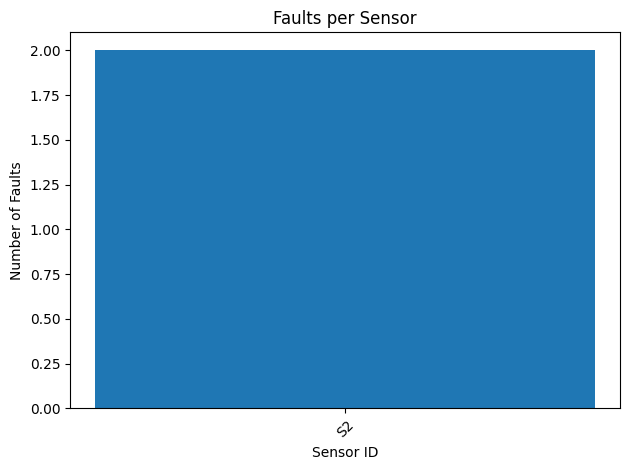

In [66]:
# 4. Plot data
import matplotlib.pyplot as plt

sensors = [x[0] for x in faults_by_sensor_rdd.collect()]
fault_counts = [x[1] for x in faults_by_sensor_rdd.collect()]


plt.figure()
plt.bar(sensors, fault_counts)
plt.xlabel("Sensor ID")
plt.ylabel("Number of Faults")
plt.title("Faults per Sensor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Since there is no indication on ploting, we will arbitrarily choose to plot the number of faults per sensor.
We take the sensor ID and the number of faults -> We plot a bar chart with the sensor ID on the x-axis and the number of faults on the y-axis.

In [67]:
sc.stop()

# Exercise 14: Bank Transactions Fraud Detection
Objective: Find suspicious transactions.

Tasks:
1. Load transactions.
2. Filter transactions over $10,000.
3. Group by account.
4. Identify accounts with multiple high-value transactions.

In [68]:
# 1. Load transactions.
sc = SparkContext("local", "ST2CBD-Lab2-BankTransactionsFraudDetection")
transactions_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/14 bank.csv")

transactions_rdd.collect()

[['T1', 'A001', '12000'],
 ['T2', 'A002', '5000'],
 ['T3', 'A001', '15000'],
 ['T4', 'A003', '20000']]

In [69]:
# 2. Filter transactions over $10,000.
high_value_transactions_rdd = transactions_rdd.filter(
    lambda fields: float(fields[2]) > 10000
)

high_value_transactions_rdd.collect()

[['T1', 'A001', '12000'], ['T3', 'A001', '15000'], ['T4', 'A003', '20000']]

We filter the transactions with a value > 10000 (index 2).

In [70]:
# 3. Group by account.
group_byaccount_rdd = (
    high_value_transactions_rdd.map(lambda fields: (fields[1], fields[0]))
    .groupByKey()
    .map(lambda fields: (fields[0], list(fields[1])))
)

group_byaccount_rdd.collect()

[('A001', ['T1', 'T3']), ('A003', ['T4'])]

We take the second field (account) and the first field (transaction ID) -> Group by account -> Create a tuple with the account and the list of transaction IDs.

In [71]:
# 4. Identify accounts with multiple high-value transactions.
multiple_high_value_accounts_rdd = group_byaccount_rdd.filter(
    lambda fields: len(fields[1]) > 1
)

multiple_high_value_accounts_rdd.collect()

[('A001', ['T1', 'T3'])]

From previous step, we filter the accounts with more than 1 transaction ID (multiple high-value transactions).

In [72]:
sc.stop()

# Exercise 15: E-commerce Product Clicks
Objective: Perform session-based analysis.

Tasks:
1. Load click logs.
2. Group clicks by session ID.
3. Count number of clicks per session.
4. Find average clicks per session

In [73]:
# 1. Load click logs.
sc = SparkContext("local", "ST2CBD-Lab2-EcommerceProductClicks")
click_logs_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/15 clicks.csv")

click_logs_rdd.collect()

[['S1', 'P1', '09:00'],
 ['S1', 'P2', '09:01'],
 ['S2', 'P1', '09:05'],
 ['S2', 'P3', '09:06'],
 ['S2', 'P2', '09:07']]

In [74]:
# 2. Group clicks by session ID.
group_by_session_rdd = (
    click_logs_rdd.map(lambda fields: (fields[0], fields[1]))
    .groupByKey()
    .map(lambda fields: (fields[0], list(fields[1])))
)

group_by_session_rdd.collect()

[('S1', ['P1', 'P2']), ('S2', ['P1', 'P3', 'P2'])]

We take the first field (session ID) and the second field (product ID) -> Group by session ID -> Create a tuple with the session ID and the list of product IDs.

In [75]:
# 3. Count number of clicks per session.
clicks_per_session_rdd = group_by_session_rdd.map(
    lambda fields: (fields[0], len(fields[1]))
)

clicks_per_session_rdd.collect()

[('S1', 2), ('S2', 3)]

From previous step, we take the session ID and count the number of product IDs (clicks) per session.

In [76]:
# 4. Find average clicks per session.
average_clicks_per_session = clicks_per_session_rdd.map(lambda fields: fields[1]).mean()

average_clicks_per_session

2.5

From previous step, we take the number of clicks and calculate the average with mean().

In [77]:
sc.stop()

# Exercise 16: Exercise: Delivery Time Performance
Objective: Measure delivery speed.

Tasks:
1. Load orders.
2. Calculate delivery time = Delivered - Ordered.
3. Average delivery time per region.
4. Identify delays > average

In [78]:
# 1. Load orders.
sc = SparkContext("local", "ST2CBD-Lab2-DeliveryTimePerformance")
orders_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/16 delivery.csv")

orders_rdd.collect()

[['1', 'North', '2025-05-01', '2025-05-03'],
 ['2', 'South', '2025-05-01', '2025-05-02'],
 ['3', 'East', '2025-05-01', '2025-05-05']]

In [79]:
# 2. Calculate delivery time = Delivered - Ordered.
from datetime import datetime


def parse_dates(fields) -> (str, int):
    region = fields[1]
    ordered_date = datetime.strptime(fields[2], "%Y-%m-%d")
    delivered_date = datetime.strptime(fields[3], "%Y-%m-%d")
    delivered_time = (delivered_date - ordered_date).days
    return region, delivered_time


delivery_time_rdd = orders_rdd.map(parse_dates)

delivery_time_rdd.collect()

[('North', 2), ('South', 1), ('East', 4)]

We create a function that will
1. Take the region (index 1)
2. Parse the ordered date (index 2) and delivered date (index 3) to datetime objects -> Create delivery time (in days)
3. Return a tuple with the region and the delivery time

We apply the function to the orders rdd.

In [80]:
# 3. Average delivery time per region.
average_delivery_time_rdd = delivery_time_rdd.groupByKey().mapValues(
    lambda times: sum(times) / len(times)
)

average_delivery_time_rdd.collect()

[('North', 2.0), ('South', 1.0), ('East', 4.0)]

Since we have the region and the delivery time, we group by region -> Calculate the average delivery time per region. <br>
There is no relevant information since there's only one order by region in the dataset.
To get a more relevant result, we could add a new line for a specific region with a higher delivery time to see if the average changes.

```csv
OrderID,Region,OrderedDate,DeliveredDate
1,North,2025-05-01,2025-05-03
2,South,2025-05-01,2025-05-02
3,East,2025-05-01,2025-05-05
4,East,2025-05-01,2025-05-30
```
```bash
>>> [('North', 2.0), ('South', 1.0), ('East', 16.5)]
```

In [81]:
# 4. Identify delays > average
average_delivery_time_dict = average_delivery_time_rdd.collectAsMap()
delays = delivery_time_rdd.filter(
    lambda field: field[1] > average_delivery_time_dict[field[0]]
).map(lambda field: (field[0], field[1]))

delays.collect()

[]

We convert the average delivery time rdd to a dictionary -> We filter the delivery time rdd to get the delays (delivery time > average delivery time) -> We create a tuple with all information about it.

In [82]:
sc.stop()

# Exercise 17: Web Logs Traffic Summary
Objective: Analyze visits per IP.

Tasks:
1. Load access logs.
2. Map to (IP, 1).
3. Count visits by IP.
4. Find IPs with > 3 visits.

In [83]:
# 1. Load access logs.
sc = SparkContext("local", "ST2CBD-Lab2-WebLogsTrafficSummary")
access_logs_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/17 accesslog.csv")

access_logs_rdd.collect()

[['192.168.1.1', '09:00'],
 ['192.168.1.2', '09:01'],
 ['192.168.1.1', '09:02'],
 ['192.168.1.3', '09:03'],
 ['192.168.1.1', '09:04']]

In [84]:
# 2. Map to (IP, 1).
ip_visits_rdd = access_logs_rdd.map(lambda fields: (fields[0], 1))

ip_visits_rdd.collect()

[('192.168.1.1', 1),
 ('192.168.1.2', 1),
 ('192.168.1.1', 1),
 ('192.168.1.3', 1),
 ('192.168.1.1', 1)]

In [85]:
# 3. Count visits by IP.
ip_counts_rdd = ip_visits_rdd.reduceByKey(lambda a, b: a + b)

ip_counts_rdd.collect()

[('192.168.1.1', 3), ('192.168.1.2', 1), ('192.168.1.3', 1)]

From last step, we reduce by key (IP) to count the number of visits by IP.

In [86]:
# 4. Find IPs with > 3 visits.
ips_with_more_than_3_visits = ip_counts_rdd.filter(lambda fields: fields[1] > 3)

ips_with_more_than_3_visits.collect()

[]

From last step, we filter the IPs with more than 3 visits. <br>
Since there's no IP with more than 3 visits in the dataset, we get an empty list.

In [87]:
sc.stop()

# Exercise 18: Customer Lifetime Value
Objective: Analyze total customer revenue.

Tasks:
1. Load transactions.
2. Group by customer.
3. Sum total spending.
4. Rank customers by spending.

In [88]:
# 1. Load transactions.
sc = SparkContext("local", "ST2CBD-Lab2-CustomerLifetimeValue")
transactions_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/18 customers.csv")

transactions_rdd.collect()

[['C1', '200'], ['C2', '150'], ['C1', '300'], ['C3', '100'], ['C2', '250']]

In [89]:
# 2. Group by customer.
group_by_customer_rdd = (
    transactions_rdd.map(lambda fields: (fields[0], float(fields[1])))
    .groupByKey()
    .map(lambda fields: (fields[0], list(fields[1])))
)

group_by_customer_rdd.collect()

[('C1', [200.0, 300.0]), ('C2', [150.0, 250.0]), ('C3', [100.0])]

In [90]:
# 3. Sum total spending.
total_spending_rdd = group_by_customer_rdd.map(
    lambda fields: (fields[0], sum(fields[1]))
)

total_spending_rdd.collect()

[('C1', 500.0), ('C2', 400.0), ('C3', 100.0)]

For each customer, we take the first field (customer ID) and the second field (spending) -> We group by customer -> We create a tuple with the customer ID and the list of spending -> We sum the spending for each customer.

In [91]:
# 4. Rank customers by spending.
ranked_customers_rdd = total_spending_rdd.sortBy(
    lambda fields: fields[1], ascending=False
)

ranked_customers_rdd.collect()

[('C1', 500.0), ('C2', 400.0), ('C3', 100.0)]

From last step, we sort by spending (index 1) to rank the customers by spending.

In [92]:
sc.stop()

# Exercise 19: Covid Case Trend Analysis
Objective: Time-series aggregation.

Tasks:
1. Load covid daily data.
2. Group by date.
3. Sum total cases.
4. Compute daily growth.

In [93]:
# 1. Load covid daily data.
sc = SparkContext("local", "ST2CBD-Lab2-CovidCaseTrendAnalysis")
covid_data_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/covid.csv")

covid_data_rdd.collect()

[['2025-05-01', 'NY', '100'],
 ['2025-05-01', 'CA', '120'],
 ['2025-05-02', 'NY', '150'],
 ['2025-05-02', 'CA', '130']]

In [94]:
# 2. Group by date. Sum total cases.
daily_cases = (
    covid_data_rdd.map(lambda x: (x[0], int(x[2])))
    .reduceByKey(lambda a, b: a + b)
    .sortByKey()
)

daily_cases.collect()

[('2025-05-01', 220), ('2025-05-02', 280)]

In [95]:
# 4. Compute daily growth.

daily_sorted = daily_cases.collect()
growth = [
    (daily_sorted[i][0], daily_sorted[i][1] - daily_sorted[i - 1][1])
    for i in range(1, len(daily_sorted))
]

print("Daily Totals:", daily_sorted)
print("Daily Growth:", growth)

Daily Totals: [('2025-05-01', 220), ('2025-05-02', 280)]
Daily Growth: [('2025-05-02', 60)]


We take the first field (date) and the third field (cases) -> We reduce by key (date) to sum the total cases per date -> We sort by date. <br>
We create a list with the date and the growth (current day - previous day) -> We print the daily totals and the daily growth.

In [96]:
sc.stop()

# Exercise 20: Real-Time Chat Logs Analysis
Objective: Analyze chat frequency per user.

Tasks:
1. Load chat logs.
2. Count messages per user.
3. Identify top 3 most active users.
4. Filter users with < 2 messages

In [97]:
# 1. Load chat logs.
sc = SparkContext("local", "ST2CBD-Lab2-RealTimeChatLogsAnalysis")
chat_logs_rdd = parse_rdd_csv(f"{DIR_CONTEXT}/20 chatlog.csv")

chat_logs_rdd.collect()

[['Alice', 'Hello!'],
 ['Bob', 'Hi!'],
 ['Alice', 'How are you?'],
 ['Charlie', 'Hey!'],
 ['Alice', 'Welcome!']]

In [98]:
# 2. Count messages per user.
user_messages_rdd = chat_logs_rdd.map(lambda fields: (fields[0], 1)).reduceByKey(
    lambda a, b: a + b
)

user_messages_rdd.collect()

[('Alice', 3), ('Bob', 1), ('Charlie', 1)]

In [99]:
# 3. Identify top 3 most active users.

top_3_active_users = user_messages_rdd.sortBy(
    lambda fields: fields[1], ascending=False
).take(3)

top_3_active_users

[('Alice', 3), ('Bob', 1), ('Charlie', 1)]

Result is not relevant since there are only 3 users in the dataset.

In [100]:
# 4. Filter users with < 2 messages
less_than_2_messages = user_messages_rdd.filter(lambda fields: fields[1] < 2)

less_than_2_messages.collect()

[('Bob', 1), ('Charlie', 1)]

In [101]:
sc.stop()